# Document AI Form Parser Visualizer
This notebook shows you how to analyze a pdf using the Google Cloud DocumentAI API

In [1]:
# Install necessary Python libraries
!pip install google-cloud-documentai
!pip install wand
!pip install pillo
!pip install tabulate

!apt-get update
!apt-get install libmagickwand-dev

ERROR: Could not find a version that satisfies the requirement pillo
ERROR: No matching distribution found for pillo
Reading package lists... Done
E: Could not open lock file /var/lib/apt/lists/lock - open (13: Permission denied)
E: Unable to lock directory /var/lib/apt/lists/
E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
from google.cloud import documentai_v1beta3 as documentai
from wand.image import Image as WImage
from PIL import Image, ImageDraw

import os
import pandas as pd
from tabulate import tabulate

## Download our sample pdf from GCS

In [3]:
PDF_URI = "gs://cesummit_workshop_data/invoice.pdf" #@param {type: "string"}

In [4]:
# Download the doc
!gsutil cp $PDF_URI ./invoice.pdf

Copying gs://cesummit_workshop_data/invoice.pdf...
/ [1 files][ 86.9 KiB/ 86.9 KiB]                                                
Operation completed over 1 objects/86.9 KiB.                                     


## Set your processor variables 

In [5]:
PROJECT_ID = "docai-internal-demo"
LOCATION = "us"  # Format is 'us' or 'eu'
PROCESSOR_ID = "826a9e08bb9f60b3"  # Create processor in Cloud Console

The following code calls the synchronous API and parses the form fields and values.

In [6]:
def process_document_sample():
    # Instantiates a client
    client = documentai.DocumentProcessorServiceClient()

    # The full resource name of the processor, e.g.:
    # projects/project-id/locations/location/processor/processor-id
    # You must create new processors in the Cloud Console first
    name = f"projects/{PROJECT_ID}/locations/{LOCATION}/processors/{PROCESSOR_ID}"

    with open('GeorgeSavageW9.pdf', "rb") as image:
        image_content = image.read()

    # Read the file into memory
    document = {"content": image_content, "mime_type": "application/pdf"}

    # Configure the process request
    request = {"name": name, "document": document}

    # Recognizes text entities in the PDF document
    result = client.process_document(request=request)
    document = result.document
    entities = document.entities
    print("Document processing complete.\n\n")
    
    if result.human_review_operation:
        print ("Triggered HITL operation: {}".format(result.human_review_operation))

    # For a full list of Document object attributes, please reference this page: https://googleapis.dev/python/documentai/latest/_modules/google/cloud/documentai_v1beta3/types/document.html#Document  

    types = []
    values = []
    confidence = []
    
    # Grab each key/value pair and their corresponding confidence scores.
    for entity in entities:
        types.append(entity.type_)
        values.append(entity.mention_text)
        confidence.append(round(entity.confidence,4))
        
    # Create a Pandas Dataframe to print the values in tabular format. 
    df = pd.DataFrame({'Type': types, 'Value': values, 'Confidence': confidence}) 
    print(tabulate(df, headers='keys', tablefmt='psql'))

    return document


def get_text(doc_element: dict, document: dict):
    """
    Document AI identifies form fields by their offsets
    in document text. This function converts offsets
    to text snippets.
    """
    response = ""
    # If a text segment spans several lines, it will
    # be stored in different text segments.
    for segment in doc_element.text_anchor.text_segments:
        start_index = (
            int(segment.start_index)
            if segment in doc_element.text_anchor.text_segments
            else 0
        )
        end_index = int(segment.end_index)
        response += document.text[start_index:end_index]
    return response



In [7]:
doc = process_document_sample()

Document processing complete.


+----+------------------+-----------------------------------+--------------+
|    | Type             | Value                             |   Confidence |
|----+------------------+-----------------------------------+--------------|
|  0 | FormRevisionDate | October 2018                      |       0.9754 |
|  1 | Name             | George Savage                     |       0.9967 |
|  2 | Address          | 309-311 Shirley Road              |       0.992  |
|  3 | CityStateZip     | Freemantle, Southampton, SO15 3HW |       0.9766 |
|  4 | AccountNumbers   | 013203673217EUR                   |       0.9922 |
|  5 | SSN              | 379067756                         |       0.997  |
|  6 | HasSignature     | NO                                |       0.9    |
|  7 | HasSignatureDate | NO                                |       0.9    |
+----+------------------+-----------------------------------+--------------+


## Draw the bounding boxes
We will now download the pdf above a jpg and use the spatial data to mark our values.

In [8]:
JPG_URI = "gs://cesummit_workshop_data/invoice.jpg" #@param {type: "string"}

In [9]:
# Download the doc
!gsutil cp $JPG_URI ./invoice.jpg

Copying gs://cesummit_workshop_data/invoice.jpg...
/ [1 files][131.0 KiB/131.0 KiB]                                                
Operation completed over 1 objects/131.0 KiB.                                    


In [10]:
im = Image.open('GeorgeSavageW9.jpg')
draw = ImageDraw.Draw(im)
for entity in doc.entities:
    # Draw the bounding box around the entities
    vertices = []
    for vertex in entity.page_anchor.page_refs[0].bounding_poly.normalized_vertices:
        vertices.append({'x': vertex.x * im.size[0], 'y': vertex.y * im.size[1]})
    draw.polygon([
        vertices[0]['x'], vertices[0]['y'],
        vertices[1]['x'], vertices[1]['y'],
        vertices[2]['x'], vertices[2]['y'],
        vertices[3]['x'], vertices[3]['y']], outline='blue')

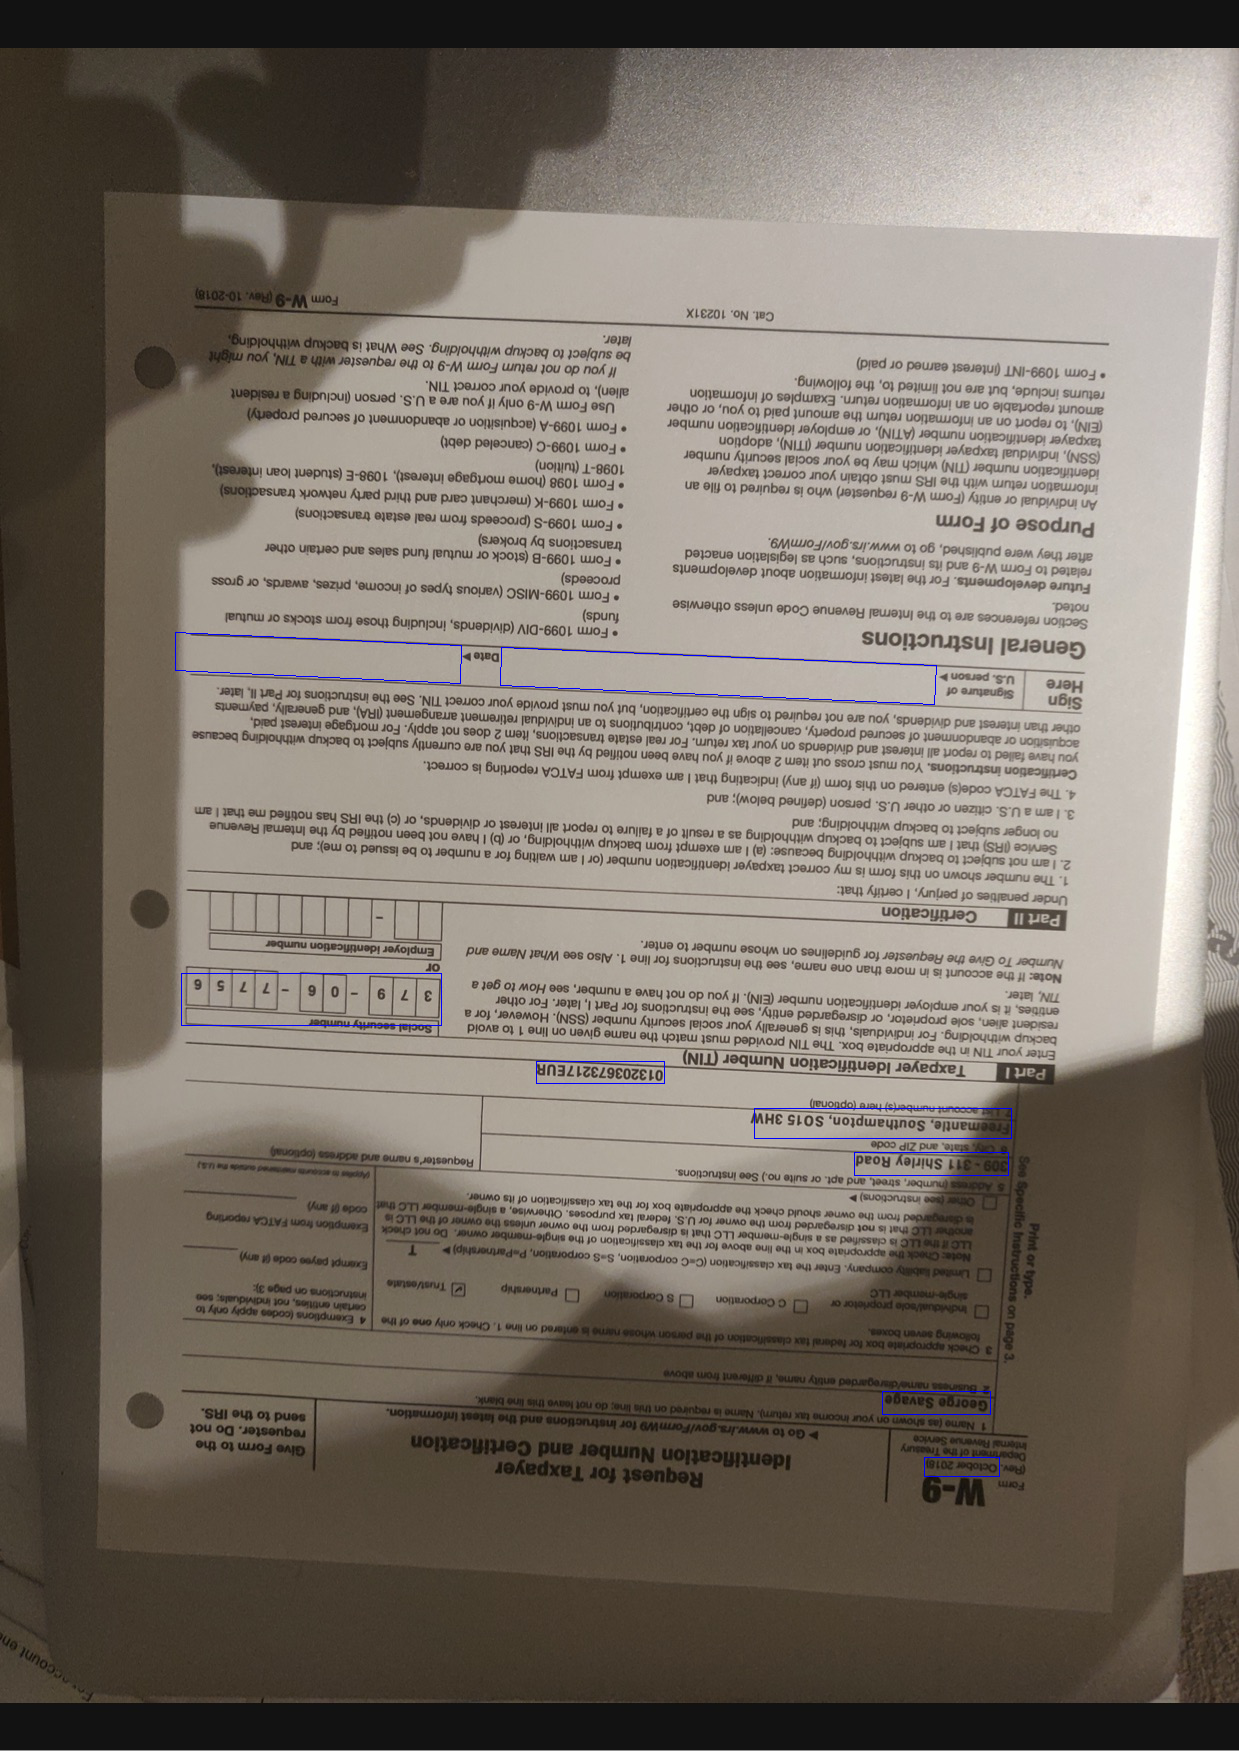

In [11]:
im

# Human in the loop (HITL) Operation

**Only complete this section if a HITL Operation is triggered**

In [12]:
lro_id = "HITL Operation" # ex. projects/660199673046/locations/us/operations/174674963333130330

In [13]:
client = documentai.DocumentProcessorServiceClient()
operation = client._transport.operations_client.get_operation(lro_id)

if operation.done:
    print("HITL location: {} ".format(str(operation.response.value)[5:-1]))
else:
    print('Waiting on human review.')

InvalidArgument: 400 Invalid operation name: 'HITL Operation'; must be either projects/<project_number_or_id>/operations/<operation_id> or projects/<project_number_or_id>/locations/<location_id>/operations/<operation_id>.

In [ ]:
!gsutil cp "HITL_LOCATION" response.json

In [ ]:
with open("response.json", "r") as file:
    import json
    entities = {}
    data = json.load(file)
    for entity in data['entities']:
        if 'mentionText' in entity:
            entities[entity['type']] = entity['mentionText']
        else:
            entities[entity['type']] = ""
    
    for t in entities:
        print("{} : {}\n ".format(t, entities[t]))